<a href="https://colab.research.google.com/github/RuoguLi0425/Robot-Learning/blob/main/Robot_Learning_Project5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Important***

**Before starting, make sure to read the [Assignment Instructions](https://courseworks2.columbia.edu/courses/172081/pages/assignment-instructions) page on Courseworks2 to learn the workflow for completing this project.**

- *Apart from the link to your notebook, you are also required to submit `q_network.pth` of Part 1 and `ppo_network.zip` (model checkpoints are loaded and saved by stable_baselines3 as zip files) of Part 2 to Coursework. You should put the link to your notebook in the comment entry.*
- *Please name the revision you want us to grade "Grade me". We will only grade the revision that is correctly named. Late days will be applied according to this named revision.*
- *Please make sure that "anyone in LionMail with the link" has Edit permissions.*

# Project Setup


In [ ]:
# DO NOT CHANGE

# After running this cell, the folder 'mecs6616_sp23_project3' will show up in the file explorer on the left (click on the folder icon if it's not open)
# It may take a few seconds to appear
!git clone https://github.com/roamlab/mecs6616_sp23_project5.git

Cloning into 'mecs6616_sp23_project5'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 43 (delta 19), reused 23 (delta 7), pack-reused 0
Unpacking objects: 100% (43/43), 13.83 KiB | 885.00 KiB/s, done.


In [ ]:
# DO NOT CHANGE

# copy all needed files into the working directory. This is simply to make accessing files easier
!cp -av /content/mecs6616_sp23_project5/* /content/

'/content/mecs6616_sp23_project5/arm_dynamics_base.py' -> '/content/arm_dynamics_base.py'
'/content/mecs6616_sp23_project5/arm_dynamics.py' -> '/content/arm_dynamics.py'
'/content/mecs6616_sp23_project5/arm_env.py' -> '/content/arm_env.py'
'/content/mecs6616_sp23_project5/geometry.py' -> '/content/geometry.py'
'/content/mecs6616_sp23_project5/render.py' -> '/content/render.py'
'/content/mecs6616_sp23_project5/robot.py' -> '/content/robot.py'
'/content/mecs6616_sp23_project5/score.py' -> '/content/score.py'


In [ ]:
# DO NOT CHANGE

# There will be error messages from this command. You can ignore those error messages
# as long as you see "Successfully installed setuptools-65.5.0" at the end.

!pip install setuptools==65.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# DO NOT CHANGE

# There will be error messages from this command. You can ignore those error messages
# as long as you see "Successfully installed gym-0.21.0 stable-baselines3-1.5.0" at the end.

!pip install gym==0.21.0 stable-baselines3==1.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.7/177.7 kB 14.9 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for gym
  Running setup.py clean for gym
Failed to build gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
  Running setup.py install for gym ... done
  DEPRECATION: gym was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. pip 23.1 will enforce this behaviour change. A possible replacement 

# Part 1: Implement DQN

For this part, you will implement DQN from scratch. You SHOULD NOT use any RL libraries.

## Starter Code Explanation
In addition to code you are already familiar with from the previous project (i.e. arm dynamics, etc.) we are providing an "Environment" in the `ArmEnv` class. The environment "wraps around" the arm dynamics and provides the key functions that an RL algorithm expects: reset(...) and step(...). The implementation of `ArmEnv` follows the [OpenAI Gym](https://www.gymlibrary.dev/api/core/) API standard. It is a standard that is accepeted by many RL libraries and allows for our problem to be easily solved with various RL libraries. Take a moment to familiarize yourself with these functions! See [here](https://www.gymlibrary.dev/api/core/) for more information on the definition of the reset(...) and step(...) functions.

Important notes:

* The ArmEnv expects an action similar to the one used previously: a vector with a torque for every arm joint. Thus, the native action space for this environment is high-dimensional, and continuous. DQN will require an action space that is 1-dimensional and discrete. You will need to convert between these. For example, you can have an action space of [0, 1, 2,] where each number just represents the identity of an action candidate, and a conversion dictionary {0: [-0.1, -0.1], 1: [0.1, 0.1], 2: [0, 0]}. Then, when the Q network output an action 1, it will be converted into [0.1, 0.1] and used by the environment. Note that this is just an example method to implement the conversion and you do not have to follow the same procedure.
* The observation provided by the environment will comprise the same state vector as before, to which we append the current position of the end_effector and the goal for the end-effector. Since your policy must learn to reach arbitrary goals, the goal must be provided as part of the observation. So the observation will consist of 8 values: 4 for the state, 2 for the pos_ee and 2 for the goal.
* The maximum episode length of the environment is 200 steps. Each step is simulated for 0.01 second. This should be used for both training and testing.
* The reward function of this environment is by default r(s, a) = - dist(pos_ee, goal)^2 where represents the negative square of L2 distance between the current position of the end-effector and the goal position.

### Arm Environment Example
You are encouraged to view the `arm_env.py` file to understand the `random_goal()`, `reset()` and `step()`  functions but do not modify the file.

The `env.reset()` method, will reset the arm in the vertically downwards position and set a new random goal by calling the `random_goal()` method. By understanding how the goals are set you could guide your training in that direction. You can also provide your own goal as a (2,1) array to the reset function as an argument. This could come handy later when training the model.

The `env.step()` function takes an action as a (2,1) shaped array and outputs the next observation, reward, done and info. `info` is a dictionary with pos_ee and vel_ee values. This can come handy if you attempt to do some reward engineering.

The cell below provides an example of random policy interacting with the ArmEnv for 50 steps (0.5 seconds)

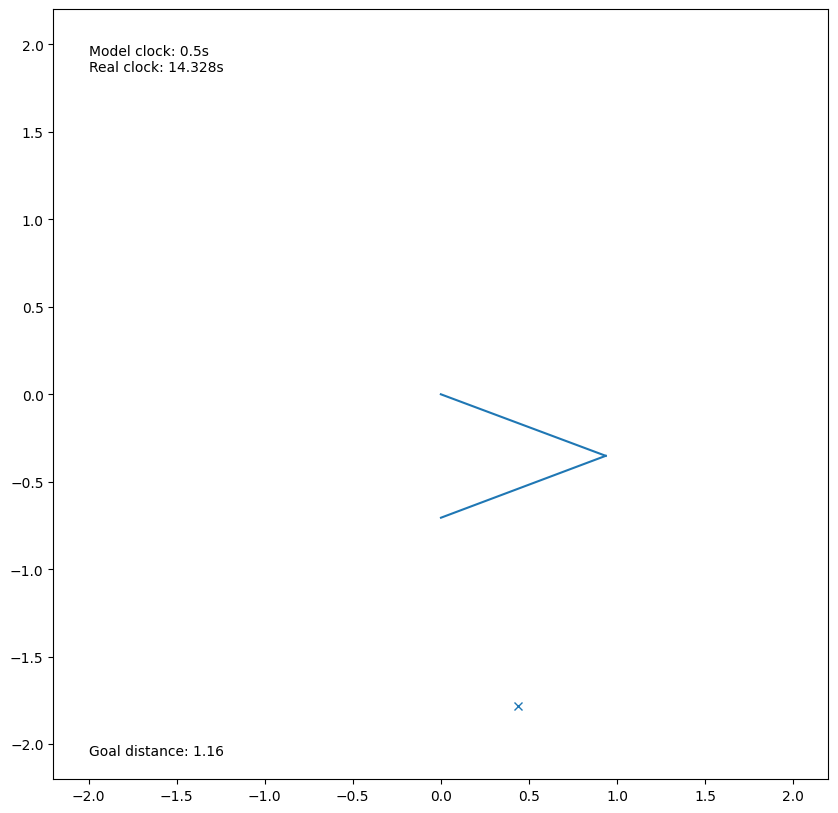

In [ ]:
from render import Renderer
from arm_env import ArmEnv
from robot import Robot
from arm_dynamics import ArmDynamics
import numpy as np

# DO NOT CHANGE arm parameters
arm = Robot(
        ArmDynamics(
            num_links=2,
            link_mass=0.1,
            link_length=1,
            joint_viscous_friction=0.1,
            dt=0.01,
	    			gravity=False
        )
    )
arm.reset()
# ------------------

env = ArmEnv(arm, gui=True)

# Passing our own defined goal to the reset function
# goal = np.array([[0.5], [-1.5]])
# obs = env.reset(goal)

# Resetting the environment without the goal will set a random goal position
obs = env.reset()

for _ in range(50):
  rand_action = np.random.uniform(-1.5, 1.5, (2,1))
  obs, reward, done, info = env.step(rand_action)

### QNetwork
This class defines the architecture of your network. You must fill in the __init__(...) function which defines your network, and the forward(...) function which performs the forward pass.

Your action space should be discrete, with whatever cardinality you decide. The size of the output layer of your Q-Network should thus be the same as the cardinality of your action space. When selecting an action, a policy must choose the one that has the highest estimated Q-value for the current state. As part of the QNetwork class, we are providing the function select_discrete_action(...) which does exactly that.

The arm environment itself however expects a 2-dimensional, continuous action vector. Therefore, when it comes to send an action to the environment, you must provide the kind of action the environment expects. It is your job to determine how to convert between the discrete action space of your Q-Network and the continuous action space of the arm. You do this by filling in the action_discrete_to_continuous(...) function in your QNetwork. You can expect to call the step function of the environment like this:

```
self.env.step(self.q_network.action_discrete_to_continuous(discrete_action))
```

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np



class QNetwork(nn.Module):
  def __init__(self, env):
    super(QNetwork, self).__init__()
    #--------- YOUR CODE HERE --------------
    self.fc1 = nn.Linear(env.observation_space.shape[0], 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 5)
    #---------------------------------------

  def forward(self, x, device):
    #--------- YOUR CODE HERE --------------
    x = torch.tensor(x, dtype=torch.float32, device=device)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
    #---------------------------------------


  def select_discrete_action(self, obs, device):
    # Put the observation through the network to estimate q values for all possible discrete actions
    est_q_vals = self.forward(obs.reshape((1,) + obs.shape), device)
    # Choose the discrete action with the highest estimated q value
    discrete_action = torch.argmax(est_q_vals, dim=1).tolist()[0]
    return discrete_action

  def action_discrete_to_continuous(self, discrete_action):
    #--------- YOUR CODE HERE --------------
    action_map = {
        0: np.array([-1.0, -1.0]),
        1: np.array([-1.0, 1.0]),
        2: np.array([1.0, -1.0]),
        3: np.array([1.0, 1.0]),
        4: np.array([0.0, 0.0]),

    }

    continuous_action = action_map[discrete_action]
    return continuous_action.reshape(2, -1)
    #---------------------------------------


We provide you with code to use the replay buffer in your RL implementation. You do not need to change the ReplayBuffer class.
```
rb = ReplayBuffer()
```
After creating a ReplayBuffer object you can add samples in the buffer using `put()`:
```
rb.put((obs, action, reward, next_obs, done))
```
Take random samples from the buffer using:
```
obs, actions, rewards, next_obses, dones = rb.sample(batch_size)
```


In [ ]:
import collections
import random
import numpy as np


class ReplayBuffer():
    def __init__(self, buffer_limit):
        self.buffer = collections.deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append(a)
            r_lst.append(r)
            s_prime_lst.append(s_prime)
            done_mask_lst.append(done_mask)

        return np.array(s_lst), np.array(a_lst), \
               np.array(r_lst), np.array(s_prime_lst), \
               np.array(done_mask_lst)

### TrainDQN
Here, you must fill in the train(...) function that actually trains your network.

We are providing a helper function called save_model(...) that will save the current Q-network. Use this as you see fit.

To set one network equal to another one, you can use code like this:
```
target_network.load_state_dict(self.q_network.state_dict())
```

If you would like to be graded with a specific seed for the random number generators, make sure to change the default seed in the initialization of the TrainDQN class.

The time taken to train the model will depend mainly on how big is your model architecture and the number of episodes you run the training for. As a reference, the time taken to train a model on 1500 episodes, which passed all evaluation metrics was about an hour.
* Reference value for clipping the gradient value as mentioned in class: 0.2
* Reference value for a typical size of Replay Buffer: >10k
* Reference value for batch size while training: 64 - 512

Note that these are just reference values and larger is not always better as it may slow things down.

It is good practice in RL to ensure simpler things are working before complicating environments or training techniques.

If you think your training method is not working at all, you could pass a fixed goal to the `env.reset()` method during the training loop to ensure that your model is learning.

In [ ]:
import time
from render import Renderer
from arm_env import ArmEnv
import numpy as np
from math import dist


class TrainDQN:

  def __init__(self, env, seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)
    self.env = env
    self.device = torch.device('cpu')
    self.q_network = QNetwork(env).to(self.device)
    self.target_network = QNetwork(env).to(self.device)
    self.target_network.load_state_dict(self.q_network.state_dict())

  def save_model(self, episode_num, save_dir='models'):
    timestr = time.strftime("%Y-%m-%d_%H-%M-%S")
    model_dir = os.path.join(save_dir, timestr)
    if not os.path.exists(os.path.join(model_dir)):
      os.makedirs(os.path.join(model_dir))
    savepath = os.path.join(model_dir, f'q_network_ep_{episode_num:04d}.pth')
    torch.save(self.q_network.state_dict(), savepath)
    print(f'model saved to {savepath}\n')


  def train(self):

    #--------- YOUR CODE HERE --------------

    import torch
    import torch.nn as nn
    import torch.optim as optim

    capacity = 10000
    replay_buffer = ReplayBuffer(buffer_limit=capacity)
    batch_size = 64
    gamma = 0.99
    learning_rate = 0.0001
    optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    epsilon = 1.0
    epsilon_decay = 0.995
    epsilon_min = 0.01
    num_episodes = 1500
    update_target_network_freq = 25

    for episode in range(num_episodes):
        episode_reward = 0
        state = self.env.reset()

        while True:
            if random.random() < epsilon:
                discrete_action = np.random.randint(0, 5)
            else:
                discrete_action = self.q_network.select_discrete_action(state, self.device)

            continuous_action = self.q_network.action_discrete_to_continuous(discrete_action)
            next_state, reward, done, _ = self.env.step(continuous_action)
            if done:
                break

            replay_buffer.put((state, discrete_action, reward, next_state, done))
            episode_reward += reward

            if len(replay_buffer.buffer) >= batch_size:
                s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = replay_buffer.sample(batch_size)
                s_lst = torch.from_numpy(s_lst).float()
                a_lst = torch.from_numpy(a_lst).long()
                r_lst = torch.from_numpy(r_lst).float()
                s_prime_lst = torch.from_numpy(s_prime_lst).float()

                q = self.q_network.forward(s_lst, self.device).gather(1, a_lst.view(-1, 1)).squeeze()
                q_t = self.target_network.forward(s_prime_lst, self.device)
                q_t_max = torch.max(q_t.detach(), dim=1)[0]
                q_tar = r_lst + gamma * q_t_max

                loss = criterion(q, q_tar)
                optimizer.zero_grad()
                loss.backward()

                for p in self.q_network.parameters():
                    p.grad.data.clamp_(-5, 5)

                optimizer.step()

            state = next_state

        if episode % update_target_network_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

        # Update epsilon
        epsilon = max(epsilon_min, epsilon_decay * epsilon)

        print("Episode:", episode, "  reward:", episode_reward)
        # Save model

        if episode % 500 == 0:
          self.save_model(episode)

    pass



In [ ]:
from robot import Robot
from arm_dynamics import ArmDynamics

# DO NOT CHANGE
# ---------------
arm = Robot(
        ArmDynamics(
            num_links=2,
            link_mass=0.1,
            link_length=1,
            joint_viscous_friction=0.1,
            dt=0.01,
	    			gravity=False
        )
    )
arm.reset()
env = ArmEnv(arm, gui=False)
tqdn = TrainDQN(env)
# ---------------

# Call your trin function here
tqdn.train()

<ipython-input-6-c8113dbe9860>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32, device=device)


Episode: 0   reward: -446.3019522580346
model saved to models/2023-05-03_03-27-08/q_network_ep_0000.pth

Episode: 1   reward: -1254.008664724819
Episode: 2   reward: -580.255641324242
Episode: 3   reward: -1071.6239544385935
Episode: 4   reward: -1135.8035200519944
Episode: 5   reward: -130.90559923589447
Episode: 6   reward: -499.35298650028903
Episode: 7   reward: -1411.4744120685266
Episode: 8   reward: -791.0382112441325
Episode: 9   reward: -581.6881160257286
Episode: 10   reward: -262.24052877579715
Episode: 11   reward: -323.56747440948953
Episode: 12   reward: -707.6383207666443
Episode: 13   reward: -1349.768181242778
Episode: 14   reward: -1393.2293445634414
Episode: 15   reward: -1070.633480897608
Episode: 16   reward: -474.1408512864749
Episode: 17   reward: -326.1851965246223
Episode: 18   reward: -840.8779605977538
Episode: 19   reward: -1003.7300303495078
Episode: 20   reward: -635.1320068036862
Episode: 21   reward: -181.1968905796687
Episode: 22   reward: -391.52858277

To keep track of your experiments, it is good practice to plot and check how well is your model trained based on the returns vs episodes plot. With a large number of episodes, this  plot may look very jagged making it difficult to ascertain how well you are doing. We are proving code to smoothen out the plot by. This will take a large list of returns in every episode and plot a smoothened version of the list. Feel free to use it if it helps.
```
import seaborn as sns
returns = __
smoothing = 10

smoothened = [sum(returns[i:i+smoothing])/smoothing for i in range(0, len(returns), smoothing)]
sns.lineplot(smoothened)
```

### Load your model and test its performance
Change your model path and the goal to see how well your learnt model is performing

In [ ]:
import collections
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from render import Renderer
from arm_env import ArmEnv
import numpy as np
import os
from math import dist
import seaborn as sns
from robot import Robot
from arm_dynamics import ArmDynamics
from geometry import polar2cartesian


# DO NOT CHANGE arm parameters
arm = Robot(
        ArmDynamics(
            num_links=2,
            link_mass=0.1,
            link_length=1,
            joint_viscous_friction=0.1,
            dt=0.01,
	    			gravity=False
        )
    )
arm.reset()
# ------------------

env = ArmEnv(arm, gui=False)
model_path = '/content/models/2023-05-03_03-38-43/q_network_ep_1000.pth' # Fill in the model_path
device = torch.device('cpu')
qnet = QNetwork(env).to(device)
qnet.load_state_dict(torch.load(model_path))
qnet.eval()
goal = polar2cartesian(1.6, 0.25 - np.pi/2.0)
done = False
obs = env.reset(goal)

episode_return = 0
while not done:
  action = qnet.select_discrete_action(obs, device)
  action = qnet.action_discrete_to_continuous(action)
  new_obs, reward, done, info = env.step(action)
  episode_return += reward

  pos_ee = info['pos_ee']
  vel_ee = info['vel_ee']
  dist = np.linalg.norm(pos_ee - goal)

  obs = new_obs
print('Episode return: ', episode_return)


Episode return:  -2.880627682702006


### Grading and Evaluation
You will be evaluated on 5 different goal positions worth 1.5 points each. You must pass the best `model_path` for your network. The scoring function will run one episode for every goal position and find the total reward (aka return) for the episode. For every goal you get:

* 1 Point if `easy target < total reward < hard target`
* 1.5 Points if `hard target < total reward`

In [ ]:
from score import compute_score
import torch.nn as nn
import torch
import torch.nn.functional as F
from render import Renderer
from arm_env import ArmEnv
from robot import Robot
from arm_dynamics import ArmDynamics
import numpy as np


# DO NOT CHANGE arm parameters
arm = Robot(
        ArmDynamics(
            num_links=2,
            link_mass=0.1,
            link_length=1,
            joint_viscous_friction=0.1,
            dt=0.01,
	    			gravity=False
        )
    )
arm.reset()
# ------------------

env = ArmEnv(arm, gui=False)
model_path = '/content/models/2023-05-03_03-38-43/q_network_ep_1000.pth' # Fill in the model_path
device = torch.device('cpu')
qnet = QNetwork(env).to(device)
qnet.load_state_dict(torch.load(model_path))
qnet.eval()
score = compute_score(qnet, env, device)

---Computing score---

Goal 1:
Total reward: -1.1449160079491505
easy target: -7
hard target: -5
points: 1.5

Goal 2:
Total reward: -2.880627682702006
easy target: -7
hard target: -5
points: 1.5

Goal 3:
Total reward: -2.697770644564659
easy target: -7
hard target: -5
points: 1.5

Goal 4:
Total reward: -3.8222012495251096
easy target: -7
hard target: -5
points: 1.5

Goal 5:
Total reward: -5.35765058493385
easy target: -10
hard target: -7
points: 1.5


Final score: 7.5


# Part 2: PPO with an open source RL library

In this part, you will use one of the most popular open source RL libraries ([Stable-Baselines3](https://stable-baselines3.readthedocs.io/en/master/)) to solve the same goal reaching problem as Part 1. We will use the same `ArmEnv` gym environment. The algorithm you should choose to use is PPO.

## PPO training

We provide the code to construct parallel environments. Parallel environments can be very useful if you have good CPUs and it can speed up training.

In [ ]:
# DO NOT CHANGE

from stable_baselines3.common.vec_env.subproc_vec_env import SubprocVecEnv
from stable_baselines3.common.vec_env.vec_monitor import VecMonitor
from copy import deepcopy
from robot import Robot
from arm_dynamics import ArmDynamics
from arm_env import ArmEnv

class EnvMaker:
    def __init__(self,  arm, seed):
        self.seed = seed
        self.arm = arm

    def __call__(self):
        arm = deepcopy(self.arm)
        env = ArmEnv(arm)
        env.seed(self.seed)
        return env

def make_vec_env(arm, nenv, seed):
    return VecMonitor(SubprocVecEnv([EnvMaker(arm, seed  + 100 * i) for i in range(nenv)]))

# conveniet function to create a robot arm
def make_arm():
    arm = Robot(
        ArmDynamics(
            num_links=2,
            link_mass=0.1,
            link_length=1,
            joint_viscous_friction=0.1,
            dt=0.01
        )
    )
    arm.reset()
    return arm


You will need to complete the code to train the policy using the [PPO class](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html) from stable_baselines3. We provide the code to generate the name of the directory to save the checkpoint, an example is `ppo_models/2023-04-13_01-14-13`. Your checkpoint model should be named `ppo_network.zip`. See the [save](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html#stable_baselines3.ppo.PPO.save) function. Training should take less than 40 minutes.

In [ ]:
from stable_baselines3.ppo import PPO
import os
import time
from stable_baselines3.common.utils import set_random_seed


# Default parameters
timesteps = 500000
nenv = 8  # number of parallel environments. This can speed up training when you have good CPUs
seed = 8
batch_size = 2048

# Generate path of the directory to save the checkpoint
timestr = time.strftime("%Y-%m-%d_%H-%M-%S")
save_dir = os.path.join('ppo_models', timestr)

# Set random seed
set_random_seed(seed)

# Create arm
arm = make_arm()

# Create parallel envs
vec_env = make_vec_env(arm=arm, nenv=nenv, seed=seed)

# ------ IMPLEMENT YOUR TRAINING CODE HERE ------------
# raise NotImplementedError


# Create PPO model
ppo_model = PPO("MlpPolicy", vec_env, verbose=1, n_steps=batch_size, seed=seed, tensorboard_log="./ppo_tensorboard/")

# Train PPO model
ppo_model.learn(total_timesteps=timesteps)

# Save the trained model
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

model_save_path = os.path.join(save_dir, "ppo_network.zip")
ppo_model.save(model_save_path)
print(f"Model saved to {model_save_path}")
# Do not forget to save your model at the end of training

Using cpu device
Logging to ./ppo_tensorboard/PPO_1
-----------------------------------
| rollout/           |            |
|    ep_len_mean     | 200        |
|    ep_rew_mean     | -200.53925 |
| time/              |            |
|    fps             | 696        |
|    iterations      | 1          |
|    time_elapsed    | 23         |
|    total_timesteps | 16384      |
-----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 200          |
|    ep_rew_mean          | -140.84149   |
| time/                   |              |
|    fps                  | 579          |
|    iterations           | 2            |
|    time_elapsed         | 56           |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 0.0060855187 |
|    clip_fraction        | 0.0604       |
|    clip_range           | 0.2          |
|    entropy_loss         | -

## Grading and evaluation

The total number of points for Part 2 is 7.5. We will evaluate your trained model on 5 random goal locations. For each test, we assign points based on the distance between the end effector and the goal location at the end of the episode.

- If 0 < distance < 0.05, you get 1.5 points.
- If 0.05 <= distance < 0.1, you get 1 point.
- If distance >= 0.1, you get 0 point.



In [ ]:
from score import score_policy
from stable_baselines3 import PPO
from stable_baselines3.common.utils import set_random_seed
from robot import Robot
from arm_dynamics import ArmDynamics
from render import Renderer
import time

# Set the path to your model
model_path = '/content/ppo_models/2023-05-03_04-00-07/ppo_network.zip'

set_random_seed(seed=100)

# Create arm robot
arm = make_arm()

# Create environment
env = ArmEnv(arm, gui=False)
env.seed(100)

# Load and test policy
policy = PPO.load(model_path)
score_policy(policy, env)


--- Computing score ---

Goal 1: 1.5

Goal 2: 1.5

Goal 3: 1.5

Goal 4: 1.5

Goal 5: 1.5


---
Final score: 7.5/7.5
---


7.5